In [2]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, column, widgetbox, layout
from bokeh.models.widgets import Dropdown, Button, Select
from bokeh.plotting import figure, ColumnDataSource
from bokeh import palettes
from bokeh.models import GraphRenderer, Oval, StaticLayoutProvider
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.models.widgets import PreText
from bokeh.models.widgets import Slider

output_notebook()

Loading BokehJS ...

In [3]:
import json
import threading
import numpy as np
import time

import logging
logging.basicConfig()

import demo

In [4]:
config = demo.get_config()

cm_client = demo.ClusterManagerClient(config["cm_endpoint"],"client",config["cm_client_secret"])

cm_client.authping()

u'authpong'

In [5]:
TEMPLATE_URL = "./deployment_template.json"

def generate_deployment(mab,models,template_url = TEMPLATE_URL,id="1"):
    deployment_template = json.load(open(template_url,'r'))
    deployment_template["id"] = id
    deployment_template["oauth_key"] = "key"+str(id)
    deployment_template["oauth_secret"] = "secret"+str(id)
    deployment_template['predictor']["name"] = "predictor_"+str(id)
    deployment_template['predictor']['predictiveUnits'][0]['cluster_resources']['image'] = mab.split(':')[0]
    deployment_template['predictor']['predictiveUnits'][0]['cluster_resources']['version'] = mab.split(':')[1]
    
    for i,model in enumerate(models):
        deployment_template['predictor']['predictiveUnits'][i+1]['cluster_resources']['image'] = model.split(':')[0]
        deployment_template['predictor']['predictiveUnits'][i+1]['cluster_resources']['version'] = model.split(':')[1]
    
    return deployment_template

n_models = 3

mabs_options = [
    ("-",None),
    ("seldonio/mab_epsilon_greedy:0.6","Epsilon Greedy"), 
    ("seldonio/mab_thomson_sampling:0.6","Thomson Sampling"), 
    ("seldonio/mab_contextual_ts:0.6","Contextual Linear"), 
    ("seldonio/mab_contextual_gbnb:0.6","Contextual Binary")]

model_options = [
    ("-",None),
    ("","Simple"),
    ("seldonio/mean_classifier:0.5","Average")]

deployment_options = ["1","2","3","4","5"]

xy_generators_dict = {
    "Normal2D":demo.Dummy2DXY()
}

reward_models_dict = {
    "Bernouilli":demo.BernouilliRouting([0.2,0.8,0.4])
}

xy_gen_options = xy_generators_dict.keys()
reward_models_options = reward_models_dict.keys()

def modify_doc_deployments(doc):
    
    globs = dict(deployments_counter = 1)
    
    def gen_delete_button_update(deployment_id, button):
        def inner():
            index = deployments_map.index(deployment_id)
            button.disabled = True
            
            cm_client.delete_deployment(deployment_id)
            
            deployments_map.pop(index)
            deployments.children.pop(index)
        return inner
    
    def click_deploy():
        mab = dropdown_mab.value
        models = [dm.value for dm in dropdown_models]
        
        button_deploy.disabled = True
        dropdown_mab.disabled = True
        for dm in dropdown_models:
            dm.disabled = True
            
        d_id = globs["deployments_counter"]
        
        deployment_string = generate_deployment(mab,models,id=str(d_id))
        cm_client.create_deployment(deployment_string)

    
        delete_button = Button(label="Delete", button_type="danger")
        delete_button.on_click(gen_delete_button_update(d_id, delete_button))
        
        deployments_map.append(d_id)
        deployments.children.append(
            widgetbox([PreText(text="Deployment "+str(d_id)),
                    delete_button]))
        
        globs["deployments_counter"] += 1
        
        button_deploy.disabled = False
        dropdown_mab.disabled = False
        for dm in dropdown_models:
            dm.disabled = False
        
    
    # Controls
    dropdown_mab = Select(title="MAB", options=mabs_options)
    dropdown_models = [Select(title="Model "+str(i), options=model_options) for i in range(n_models)]
    
    button_deploy = Button(label="Deploy", button_type="success")

    button_deploy.on_click(click_deploy)
    
    all_widgets = [dropdown_mab] + dropdown_models + [button_deploy]
    controls = widgetbox(all_widgets)
    
    deployments_map = []
    deployments = column([])
    
    p1 = figure(tools="", toolbar_location=None,plot_width = 11,plot_height=500)
    
    layout = row(controls, p1, deployments)
    doc.add_root(layout)

# Set up the Application 
handler_deployments = FunctionHandler(modify_doc_deployments)
app_deployments = Application(handler_deployments)

doc_deployments = app_deployments.create_document()



def modify_doc_clients(doc):
    
    globs = dict(clients_counter = 1)

        
    def gen_start_button_update(client,button_start,button_stop,button_delete):
        def inner():
            if client.isAlive():
                client.restart()
            else:
                client.start()
            button_start.disabled = True
            button_stop.disabled = False
            button_delete.disabled = True
        return inner
            
    def gen_stop_button_update(client,button_start,button_stop,button_delete):
        def inner():
            client.stop()
            button_start.disabled = False
            button_stop.disabled = True
            button_delete.disabled = False
        return inner

    def gen_delete_button_update(client_id, client, button):
        def inner():
            index = clients_map.index(client_id)
            button.disabled = True
            
            client.kill()
            clients_map.pop(index)
            clients.children.pop(index)
            
        return inner
            
    def gen_update_param(kw,params):
        def inner(attr,old,new):
            params[kw] = new
        return inner
    
            
    def click_create():
        
        deployment_id = dropdown_deployment.value
        xy_generator = xy_generators_dict[dropdown_generator.value]
        reward_model = reward_models_dict[dropdown_reward.value]
        
        button_create.disabled = True
            
        c_id = globs["clients_counter"]
        
        api_client = demo.APIFrontEndClient(config["api_endpoint"],"key"+deployment_id,"secret"+deployment_id)
        
        client = demo.Client(api_client,xy_generator,reward_model)
    
        start_button = Button(label="Start", button_type="success")
        stop_button = Button(label="Stop", button_type="warning", disabled=True)
        delete_button = Button(label="Delete", button_type="danger")
        
        sliders = {kw:Slider(start=0,end=1,value=reward_model.params[kw],step=0.01,title=kw) for kw in reward_model.params}
        for kw,slider in sliders.items():
            slider.on_change('value',gen_update_param(kw,reward_model.params))
        
        start_button.on_click(gen_start_button_update(client, start_button, stop_button, delete_button))
        stop_button.on_click(gen_stop_button_update(client, start_button, stop_button, delete_button))
        delete_button.on_click(gen_delete_button_update(c_id, client, delete_button))
        
        
        clients_map.append(c_id)
        clients.children.append(
            widgetbox([PreText(text="Client "+str(c_id)),
                        start_button,
                        stop_button,
                        delete_button]+sliders.values()))
        
        globs["clients_counter"] += 1
        
        button_create.disabled = False
        
            
    # Controls
    dropdown_deployment = Select(title="Deployment", options=deployment_options, value=deployment_options[0][0])
    dropdown_generator = Select(title="Features Generator", options=xy_gen_options, value= xy_gen_options[0])
    dropdown_reward = Select(title="Reward Generator", options=reward_models_options, value=reward_models_options[0])
    
    button_create = Button(label="Create Client", button_type="success")
    
    button_create.on_click(click_create)
    
    all_widgets = [dropdown_deployment, dropdown_generator, dropdown_reward, button_create]
    controls = widgetbox(all_widgets)
    
    clients_map = []
    clients = column([],responsive=True)
    
    
    p1 = figure(tools="", toolbar_location=None,plot_width = 11,plot_height=1000)
    layout = row(controls, p1, clients)
    doc.add_root(layout)

# Set up the Application 
handler_clients = FunctionHandler(modify_doc_clients)
app_clients = Application(handler_clients)

doc_clients = app_clients.create_document()



In [6]:
show(app_deployments, notebook_url="localhost:8888")
show(app_clients, notebook_url="localhost:8888")

In [9]:
2

2

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/maximux/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "demo.py", line 182, in run
    response = self.api_client.predictions(request)
  File "demo.py", line 102, in predictions
    response = self._post("/api/v0.1/predictions",data=request)
  File "demo.py", line 74, in _post
    return self._request("POST",url,data)
  File "demo.py", line 64, in _request
    raise ClientException(response.text)
ClientException: {
  "code": 103,
  "info": "Status code: 500 Reason: ",
  "reason": "Microservice error",
  "status": "FAILURE"
}



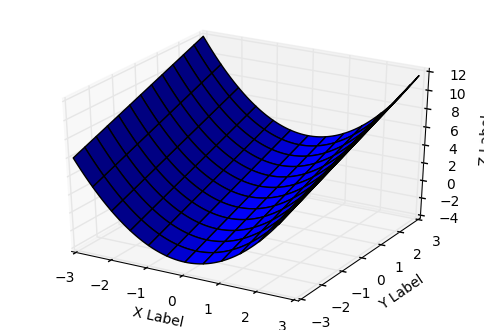

In [44]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random

def fun(x, y):
    return x**2 + y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [49]:
def modify_doc(doc):
    
    # Create the main plot
    def create_figure():
        p = figure(plot_width=600, plot_height=600)
        return p

    # Update the plot
    def update(attr, old, new):
        pass
#         print dropdown_mab.value
        
    def click_deploy():
        mab = dropdown_mab.value
        models = [dm.value for dm in dropdown_models]
        
        button_deploy.disabled = True
        dropdown_mab.disabled = True
        for dm in dropdown_models:
            dm.disabled = True
        
        deployment_string = generate_deployment(mab,models)
        cm_client.create_deployment(deployment_string)
        
        circles.glyph.fill_color = "green"
        button_delete.disabled=False
        
    def click_delete():
        button_delete.disabled = True
        
        cm_client.delete_deployment(1)
        
        circles.glyph.fill_color = "yellow"
        button_deploy.disabled = False
        dropdown_mab.disabled = False
        for dm in dropdown_models:
            dm.disabled = False
            
    p = figure(tools="", toolbar_location=None, x_range=(-1.5,1.5), y_range=(-1.5,0.5))
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    N = 4 
    
    x = [0,-1,0,1]
    y = [0,-1,-1,-1]
    texts = ["MAB","Model 1", "Model 2", "Model 3"]
    
    text = ColumnDataSource(dict(x=x,y=y,text=texts))
    vertices = ColumnDataSource(dict(x=x,y=y))
    edges = ColumnDataSource(dict(x0=x[0:1]*(N-1),y0=y[0:1]*(N-1),x1=x[1:],y1=y[1:]))
    
    p.segment('x0','y0','x1','y1',source=edges,line_color="black")
    circles = p.circle('x','y',radius=0.3,source=vertices,line_color="black",fill_color="yellow")
    p.text('x','y','text',source=text, text_align="center", text_baseline="middle")
    
    # Controls
    dropdown_mab = Select(title="MAB", options=mabs_options)
    dropdown_models = [Select(title="Model "+str(i), options=model_options) for i in range(n_models)]
    
    button_deploy = Button(label="Deploy", button_type="success")
    button_delete = Button(label="Delete", button_type="danger",disabled=True)
    
    dropdown_mab.on_change('value', update)
    for dm in dropdown_models:
        dm.on_change('value', update)
    button_deploy.on_click(click_deploy)
    button_delete.on_click(click_delete)
    
    all_widgets = [dropdown_mab] + dropdown_models + [button_deploy,button_delete]
    controls = widgetbox(all_widgets)
    
    layout = row(controls, p)
    doc.add_root(layout)

# Set up the Application 
handler = FunctionHandler(modify_doc)
app = Application(handler)

doc = app.create_document()

show(app, notebook_url="localhost:8888")

In [15]:
def track_kwargs(func):
    def inner(self,*args,**kwargs):
        self.kwargs = kwargs.keys()
        return func(self,*args,**kwargs)
    return inner

In [19]:
class Test(object):
    @track_kwargs
    def __init__(self,a=3):
        self.a = 3

In [20]:
t = Test(a=5)

In [21]:
t.kwargs

['a']